# INTENT CLASSIFICATION

## PROJECT WORK #2 - NLP - FEUP
### Filippo Comastri - Benedek Lellei - Amanda Oliveira 

Our task is to classify queries into different intent classes. Queries are very short sentences, usually some questions or prompt commands about specific topics.

The purpose of the second assignment is to try large pretrained language models to accomplish the above task and compare the results with those of basic natural language processing techniques and "traditional" machine learning classification methods tried with the first assignment.

We tried three different models found on Huggingface to see the performance of trasformer-based deep neural networks.

## Imports

In [ ]:
! pip install datasets transformers accelerate

In [ ]:
import pandas as pd
from datasets import load_dataset
import json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForMaskedLM
from transformers import pipeline
from transformers import TextClassificationPipeline
from transformers import DataCollatorForLanguageModeling
from datasets import load_metric
import numpy as np
import math
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading dataset

In [ ]:
# If you're using Colab, you need to upload the file data_full.json in the runtime

def get_df_hf(oos=False) :
    with open('data_full.json') as json_file: 
        data_dict = json.load(json_file) 

    train_data = data_dict['train']
    val_data = data_dict['val']
    test_data = data_dict['test']

    oos_train = data_dict['oos_train']
    oos_val = data_dict['oos_val']
    oos_test = data_dict['oos_test']


    train_df = pd.DataFrame(train_data, columns =['query', 'label'])
    val_df = pd.DataFrame(val_data, columns =['query', 'label'])
    test_df = pd.DataFrame(test_data, columns =['query', 'label'])

    train_oos_df = pd.DataFrame(oos_train,columns=['query','label'])
    val_oos_df = pd.DataFrame(oos_val,columns=['query','label'])
    test_oos_df = pd.DataFrame(oos_test,columns=['query','label'])

    if oos :
        # Concatenate dataframes to consider oos as a specific intent
        train_df = pd.concat([train_df,train_oos_df])
        val_df = pd.concat([val_df,val_oos_df])
        test_df = pd.concat([test_df,test_oos_df])

    unique_labels = train_df['label'].unique()
    labels_dict = {i: v for i, v in enumerate(unique_labels)}

    train_df['label'], _ = pd.factorize(train_df['label'])
    val_df['label'], _ = pd.factorize(val_df['label'])
    test_df['label'], _ = pd.factorize(test_df['label'])

    # Map the integer labels to string labels
    #df['label'] = label_mapping.take(df['label'])
    
    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), Dataset.from_pandas(test_df), labels_dict

train_df, val_df, test_df, label_mapping = get_df_hf()
train_valid_test_dataset = DatasetDict({
    'train': train_df,
    'validation': val_df,
    'test': test_df
})

num_labels = 150

train_valid_test_dataset


DatasetDict({
    train: Dataset({
        features: ['query', 'label'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label'],
        num_rows: 4500
    })
})

## Define preprocessing and evaluation functions

In [ ]:
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

# we only want to display accuracy during the training process
def compute_metrics_train(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return accuracy_metric.compute(predictions=predictions, references=labels)

# we will display all four metrics (used during the first assignment)
def compute_metrics_eval(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro") 
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro") 
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro") 
    return { "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1 }

# preprocessing function for training the classification head
def preprocess_function(sample):
    return tokenizer(sample["query"], truncation=True, padding=True, return_tensors='pt')

# preprocessing function for the domain adaptation fine-tuning
def preprocess_function_d_adapt(examples):
    result = tokenizer(examples["query"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Pre-processing function to apply before masked language modeling
chunk_size = 8

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

# function to obtain the most commonly misclassified intent classes
def compare_misclassification(y_test, y_pred):
    # Generate a confusion matrix with label indices
    conf_matrix = confusion_matrix(y_test, y_pred)

    labels = sorted(list(set(y_test)))
    for class1_idx in range(len(labels)):
        for class2_idx in range(len(labels)):
            # Get the name the two classes
            class1 = labels[class1_idx]
            class2 = labels[class2_idx]
            if(class1 != class2):
                # Get the total number of samples 
                class1_queries = sum(conf_matrix[class1_idx])

                # Get the number of misclassifications 
                misclassifications_class1 = conf_matrix[class1_idx][class2_idx] 
                
                # Calculate the percentage of misclassifications 
                percent_misclassified = (misclassifications_class1 / class1_queries) * 100
                if percent_misclassified > 10.0:
                    print(f"Percentage of '"+ class1 + "' queries misclassified as'" + class2 + "': {:.2f}%".format(percent_misclassified))


## HugginFace login

We will need this login later to push the fine-tuned model on the hub.

In [ ]:
notebook_login()

## Models used
- DistillBERT: the baseline
- BERT-large: the largest one
- XLM-RoBERTa-base fine-tuned on Amazon Massive dataset (intent classification dataset)

## *Distilled BERT* - the baseline

As a baseline we used a distilled version of BERT (which was already used during the lesson) because it is a rather small model in terms of parameter count and yet can provide reasonable results.

#### Tokenizer

In [ ]:
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping)

#### Fine-tune the classification head using a Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.326100,1.959851,0.840667
2,1.470900,0.760012,0.917333
3,0.620900,0.543852,0.935000


TrainOutput(global_step=2814, training_loss=1.830068185639534, metrics={'train_runtime': 202.1073, 'train_samples_per_second': 222.654, 'train_steps_per_second': 13.923, 'total_flos': 379476929590560.0, 'train_loss': 1.830068185639534, 'epoch': 3.0})

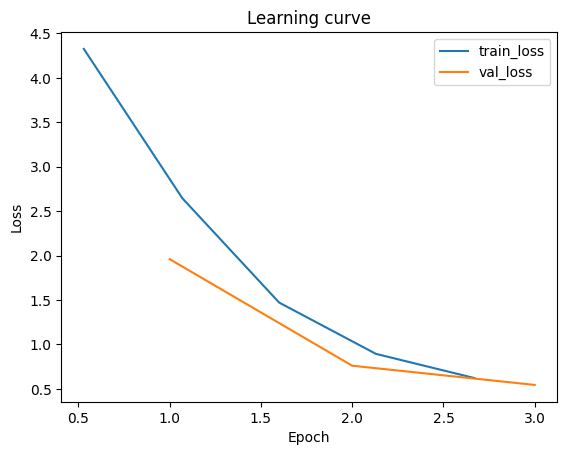

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

#### Saving the model

In [ ]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9288888888888889}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9326290438272785}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.928888888888889}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9281772325992623}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5522355437278748,
 'eval_accuracy': {'accuracy': 0.9288888888888889},
 'eval_precision': {'precision': 0.9326290438272785},
 'eval_recall': {'recall': 0.928888888888889},
 'eval_f1': {'f1': 0.9281772325992623},
 'eval_runtime': 6.4823,
 'eval_samples_per_second': 694.202,
 'eval_steps_per_second': 86.852}

The results are already comparable with those achieved during the first assignment in all the metrics. Let's try fine-tuning the language model on our dataset.
We fine tune the language model using an unsupervised technique called "Domain Adaptation" which consists in masking some words and train the model to fill the mask with the correct word.

#### Domain adaptation

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name)

##### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

We preprocess the tokenized datasets by applying the group_texts function. This function aggregates all texts in the corpus and then divide into equally sized chunks, which are used as inputs for the model. The model can use the chunks as contexts to predict the mask.
After this we applied the DataCollatorForLanguageModeling which masks some words in each chunk.

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 20691
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4112
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6116
    })
})

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [ ]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

We print the Perplexity of the model before domain adaptation to compare with the perplexity after. As expected we'll see that, for all the models, the perplexity decreases after domain adaptation. This is because the model is more aware of the context on which is working on.

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


>>> Perplexity: 319.56


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.729900,3.183496
2,3.092100,2.944874
3,2.877800,2.864294


TrainOutput(global_step=972, training_loss=3.2325474980436724, metrics={'train_runtime': 79.8815, 'train_samples_per_second': 777.063, 'train_steps_per_second': 12.168, 'total_flos': 128569822536672.0, 'train_loss': 3.2325474980436724, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 16.99


In [ ]:
trainer.push_to_hub()

##### Fine tune the classification head
After applying domain adaptation we train a new classification head for our masked language model, to see if performances improve after domain adaptation.

In [ ]:
checkpoint = 'FilippoComastri/distilbert-base-uncased-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.256900,1.875548,0.860000
2,1.395900,0.706482,0.920000
3,0.579600,0.509707,0.936667


TrainOutput(global_step=2814, training_loss=1.7677027275991, metrics={'train_runtime': 198.1356, 'train_samples_per_second': 227.117, 'train_steps_per_second': 14.202, 'total_flos': 379476929590560.0, 'train_loss': 1.7677027275991, 'epoch': 3.0})

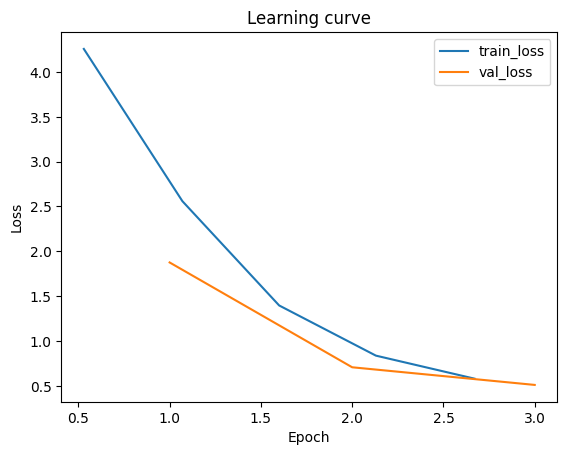

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5097074508666992,
 'eval_accuracy': 0.9366666666666666,
 'eval_runtime': 2.7523,
 'eval_samples_per_second': 1090.001,
 'eval_steps_per_second': 68.307,
 'epoch': 3.0}

In [ ]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9337777777777778}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9378107201256847}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9337777777777777}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9331136307985923}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5110357999801636,
 'eval_accuracy': {'accuracy': 0.9337777777777778},
 'eval_precision': {'precision': 0.9378107201256847},
 'eval_recall': {'recall': 0.9337777777777777},
 'eval_f1': {'f1': 0.9331136307985923},
 'eval_runtime': 5.8737,
 'eval_samples_per_second': 766.125,
 'eval_steps_per_second': 95.851}

Observing results after domain adaptation we can see that the performances are slightly better but not so much. This is probably related to the nature of the dataset, that doesn't have a very specific domain, and so even the not fine-tuned version of DistillBERT can work well on it.

##### Let's evaluate the misclassifications.
For this purpose we implemented a function that (based on the confusion matrix) lists the misclassification rates over 10%.

In [ ]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [ ]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'calendar' queries misclassified as'calendar_update': 26.67%
Percentage of 'change_user_name' queries misclassified as'change_ai_name': 30.00%
Percentage of 'gas_type' queries misclassified as'gas': 13.33%
Percentage of 'ingredient_substitution' queries misclassified as'oil_change_how': 16.67%
Percentage of 'ingredients_list' queries misclassified as'recipe': 13.33%
Percentage of 'meeting_schedule' queries misclassified as'schedule_meeting': 13.33%
Percentage of 'pto_request' queries misclassified as'pto_request_status': 30.00%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 23.33%
Percentage of 'report_fraud' queries misclassified as'transactions': 20.00%
Percentage of 'shopping_list' queries misclassified as'order': 13.33%
Percentage of 'shopping_list' queries misclassified as'shopping_list_update': 13.33%
Percentage of 'transactions' queries misclassified as'spending_history': 16.67%
Percentage of 'what_is_your_name' queries misclassified as'u

Although the performance metrics improved compared the results of the first assignment, there is still a high rate of misclassification among similar intent classes.

For the rest of the above listed models we followed the same process for training and evaluation so we won't describe it in more details.

## *BERT-large*

The next model was BERT-large which is the largest one among the ones that we used. It is pretrained on a large wide-domain corpora (Wikipedia and BookCorpus), the same as DistilBert.

#### Tokenizer

In [ ]:
model_name = "bert-large-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping)

#### Fine-tune the classification head using a Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.500300,0.474434,0.949333
2,0.276300,0.169353,0.969000
3,0.059600,0.150750,0.969333


TrainOutput(global_step=2814, training_loss=0.8796698462480167, metrics={'train_runtime': 1335.8498, 'train_samples_per_second': 33.686, 'train_steps_per_second': 2.107, 'total_flos': 2663990449407264.0, 'train_loss': 0.8796698462480167, 'epoch': 3.0})

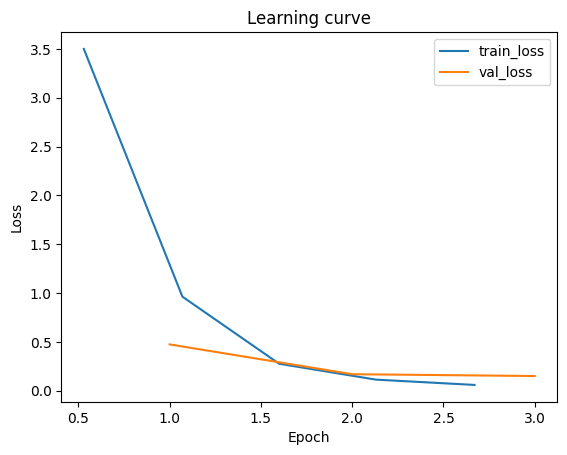

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

#### Saving the model

In [ ]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9695555555555555}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9708933761696947}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9695555555555557}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9695187949664357}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.1609278917312622,
 'eval_accuracy': {'accuracy': 0.9695555555555555},
 'eval_precision': {'precision': 0.9708933761696947},
 'eval_recall': {'recall': 0.9695555555555557},
 'eval_f1': {'f1': 0.9695187949664357},
 'eval_runtime': 33.4117,
 'eval_samples_per_second': 134.683,
 'eval_steps_per_second': 16.85}

#### Domain adaptation

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 20691
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4112
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6116
    })
})

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [ ]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 2459.14


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.666600,2.958910
2,2.882900,2.750730
3,2.621600,2.625599


TrainOutput(global_step=972, training_loss=3.05598468937501, metrics={'train_runtime': 387.4759, 'train_samples_per_second': 160.198, 'train_steps_per_second': 2.509, 'total_flos': 903962426897376.0, 'train_loss': 3.05598468937501, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 14.23


In [ ]:
trainer.push_to_hub()

##### Fine tune the classification head

In [ ]:
checkpoint = 'FilippoComastri/bert-large-uncased-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.585900,0.245828,0.959667
2,0.124300,0.149699,0.970333
3,0.037400,0.148575,0.970667


TrainOutput(global_step=2814, training_loss=0.5847601399153958, metrics={'train_runtime': 1503.2671, 'train_samples_per_second': 29.935, 'train_steps_per_second': 1.872, 'total_flos': 2663990449407264.0, 'train_loss': 0.5847601399153958, 'epoch': 3.0})

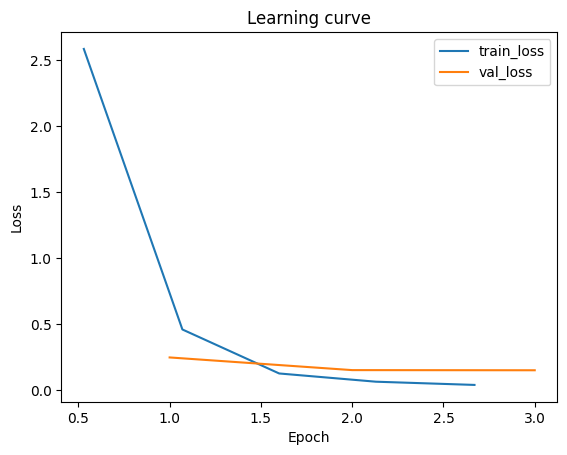

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14857544004917145,
 'eval_accuracy': 0.9706666666666667,
 'eval_runtime': 19.6025,
 'eval_samples_per_second': 153.041,
 'eval_steps_per_second': 9.591,
 'epoch': 3.0}

In [ ]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9702222222222222}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.971735675393187}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9702222222222224}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9702076205645422}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.1637600064277649,
 'eval_accuracy': {'accuracy': 0.9702222222222222},
 'eval_precision': {'precision': 0.971735675393187},
 'eval_recall': {'recall': 0.9702222222222224},
 'eval_f1': {'f1': 0.9702076205645422},
 'eval_runtime': 34.3115,
 'eval_samples_per_second': 131.151,
 'eval_steps_per_second': 16.409}

Observing results are significanty better than using DistilledBert but domain adaptation did not improve a lot either.

##### Let's evaluate the misclassifications.

In [ ]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [ ]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'pin_change' queries misclassified as'change_ai_name': 16.67%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 16.67%
Percentage of 'transactions' queries misclassified as'spending_history': 13.33%


The quantity of misclassified intent classes decreased by a great amount. The incerease of performace might be because of the higher parameter count of BERT-large compared to DistilledBert.

## *XLM-RoBERTa* - fine-tuned on Amazon Massive

This is a smaller model respect to BERT-large but it's fine-tuned on the Amazon Massive dataset which is designed for intent classification (same as our task).

#### Tokenizer

In [ ]:
model_name = "cartesinus/xlm-r-base-amazon-massive-intent"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping, ignore_mismatched_sizes=True)

#### Fine-tune the classification head using a Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.747400,1.399283,0.884667
2,1.171700,0.527504,0.942000
3,0.497100,0.370056,0.956333


Epoch,Training Loss,Validation Loss,Accuracy
1,3.747400,1.399283,0.884667
2,1.171700,0.527504,0.942000
3,0.497100,0.370056,0.956333


TrainOutput(global_step=2814, training_loss=1.5152018858171474, metrics={'train_runtime': 719.8169, 'train_samples_per_second': 62.516, 'train_steps_per_second': 3.909, 'total_flos': 940999238299008.0, 'train_loss': 1.5152018858171474, 'epoch': 3.0})

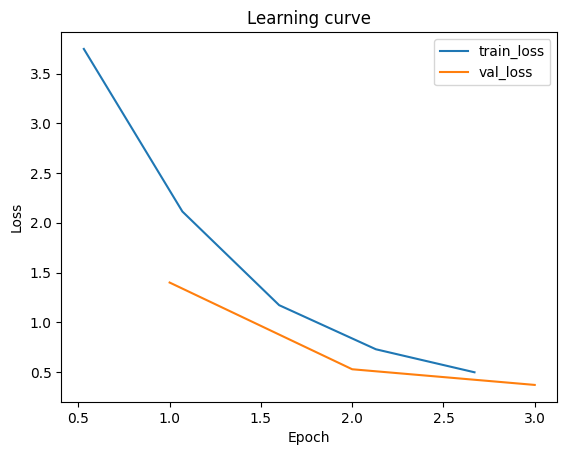

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

#### Saving the model

In [ ]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.946}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9485875122658759}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9460000000000002}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9459286935455722}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.4002804160118103,
 'eval_accuracy': {'accuracy': 0.946},
 'eval_precision': {'precision': 0.9485875122658759},
 'eval_recall': {'recall': 0.9460000000000002},
 'eval_f1': {'f1': 0.9459286935455722},
 'eval_runtime': 18.0475,
 'eval_samples_per_second': 249.342,
 'eval_steps_per_second': 31.195}

#### Domain adaptation

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at cartesinus/xlm-r-base-amazon-massive-intent were not used when initializing XLMRobertaForMaskedLM: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForMaskedLM were not initialized from the model checkpoint at cartesinus/xlm-r-base-amazon-massive-intent and are newly initialized: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bi

##### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 21844
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4365
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6471
    })
})

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [ ]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


>>> Perplexity: 464328993962.49


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,8.296800,6.637293
2,6.525200,6.232546
3,6.254600,6.103693


TrainOutput(global_step=1026, training_loss=7.023199726498848, metrics={'train_runtime': 509.1464, 'train_samples_per_second': 128.71, 'train_steps_per_second': 2.015, 'total_flos': 270195660247680.0, 'train_loss': 7.023199726498848, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 458.88


In [ ]:
trainer.push_to_hub()

##### Fine tune the classification head

In [ ]:
checkpoint = 'FilippoComastri/xlm-r-base-amazon-massive-intent-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping, ignore_mismatched_sizes=True)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.120200,1.805004,0.876333
2,1.530200,0.731174,0.934333
3,0.708100,0.519535,0.943667


TrainOutput(global_step=2814, training_loss=1.8278881905344928, metrics={'train_runtime': 733.0726, 'train_samples_per_second': 61.385, 'train_steps_per_second': 3.839, 'total_flos': 940999238299008.0, 'train_loss': 1.8278881905344928, 'epoch': 3.0})

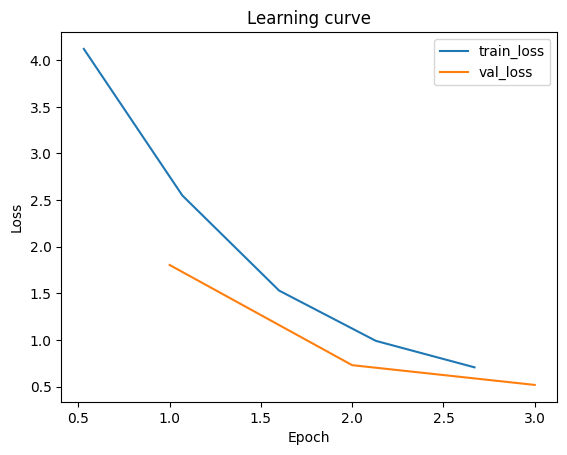

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5195347666740417,
 'eval_accuracy': 0.9436666666666667,
 'eval_runtime': 6.3298,
 'eval_samples_per_second': 473.949,
 'eval_steps_per_second': 29.701,
 'epoch': 3.0}

In [ ]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9382222222222222}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9407788070230458}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9382222222222223}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9375213272004275}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5372381806373596,
 'eval_accuracy': {'accuracy': 0.9382222222222222},
 'eval_precision': {'precision': 0.9407788070230458},
 'eval_recall': {'recall': 0.9382222222222223},
 'eval_f1': {'f1': 0.9375213272004275},
 'eval_runtime': 11.1557,
 'eval_samples_per_second': 403.382,
 'eval_steps_per_second': 50.468}

We can observe that after domain adaptation the performances don't improve but they are even worse. 

##### Let's evaluate the misclassifications.

In [ ]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [ ]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'account_blocked' queries misclassified as'freeze_account': 16.67%
Percentage of 'apr' queries misclassified as'interest_rate': 23.33%
Percentage of 'calendar' queries misclassified as'calendar_update': 16.67%
Percentage of 'change_ai_name' queries misclassified as'change_user_name': 13.33%
Percentage of 'change_user_name' queries misclassified as'change_ai_name': 16.67%
Percentage of 'change_volume' queries misclassified as'change_speed': 13.33%
Percentage of 'damaged_card' queries misclassified as'replacement_card_duration': 13.33%
Percentage of 'damaged_card' queries misclassified as'report_lost_card': 13.33%
Percentage of 'pto_balance' queries misclassified as'pto_used': 13.33%
Percentage of 'shopping_list' queries misclassified as'todo_list': 13.33%
Percentage of 'transactions' queries misclassified as'spending_history': 13.33%
Percentage of 'what_is_your_name' queries misclassified as'user_name': 33.33%


## Conclusions

The best performing model we tried was BERT-large which is also the largest one. So in our case it looks like that the larger the model is, the better the performances are.

Our results with *XLM-RoBERTa* led us to assume that if we find some model that is already fine tuned on a similar dataset or task, domain adaptation may not be worth it.

Also in general, domain adaptation did not bring very significant improvements in our case. (This was true for the larger models especially.) This is maybe linked to the nature of our dataset, which is rather general in terms of corpora domain. That can be the reason why the pretrained models (pretrained on corpora of many different domains) already reach their peak performance without domain adaptation.

All in all, deep learning (and transformer-based) approaches proved to be very efficient for our specific intent-classification task, even compared to the (already good-performing) "classical" techniques we tried during the first assignment.